# Day 13 — Inception & GoogLeNet


## Overview
In this notebook, we implement a simplified **Inception (GoogLeNet)** architecture for **CIFAR-10** using TensorFlow/Keras. This model demonstrates how parallel convolutions of different kernel sizes allow multi-scale feature extraction efficiently.

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models, datasets, utils, callbacks
import matplotlib.pyplot as plt

tf.random.set_seed(42)

## Load and Prepare Dataset

In [6]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train, y_test = utils.to_categorical(y_train, 10), utils.to_categorical(y_test, 10)


print(f"Training data: {x_train.shape}, Labels: {y_train.shape}")
print(f"Test data: {x_test.shape}, Labels: {y_test.shape}")

Training data: (50000, 32, 32, 3), Labels: (50000, 10)
Test data: (10000, 32, 32, 3), Labels: (10000, 10)


## Define Inception Block

In [7]:
def inception_block(x, f1, f3_in, f3, f5_in, f5, pool_proj):
    path1 = layers.Conv2D(f1, 1, padding='same', activation='relu')(x)


    path2 = layers.Conv2D(f3_in, 1, padding='same', activation='relu')(x)
    path2 = layers.Conv2D(f3, 3, padding='same', activation='relu')(path2)


    path3 = layers.Conv2D(f5_in, 1, padding='same', activation='relu')(x)
    path3 = layers.Conv2D(f5, 5, padding='same', activation='relu')(path3)


    path4 = layers.MaxPooling2D(3, strides=1, padding='same')(x)
    path4 = layers.Conv2D(pool_proj, 1, padding='same', activation='relu')(path4)


    return layers.concatenate([path1, path2, path3, path4], axis=-1)

## Build the Simplified Inception Model

In [8]:
def build_inception(input_shape=(32, 32, 3), num_classes=10):
    inputs = layers.Input(shape=input_shape)


    x = layers.Conv2D(64, 3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling2D(2)(x)


    x = inception_block(x, 32, 48, 64, 8, 16, 16)
    x = inception_block(x, 64, 64, 96, 16, 32, 32)
    x = layers.MaxPooling2D(2)(x)
    x = inception_block(x, 64, 96, 128, 16, 32, 32)


    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)


    return models.Model(inputs, outputs, name="SimpleInceptionNet")


model = build_inception()
model.summary()

Model: "SimpleInceptionNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 16, 16,    │      3,120 │ max_pooling2d_5[… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 16, 16, 8) │        520 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ max_pooling2d_5[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 16, 16,    │      2,080 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 16, 16,    │     27,712 │ conv2d_21[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 16, 16,    │      3,216 │ conv2d_23[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │      1,040 │ max_pooling2d_6[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 16, 16,    │          0 │ conv2d_20[0][0],  │
│ (Concatenate)       │ 128)              │            │ conv2d_22[0][0],  │
│                     │                   │            │ conv2d_24[0][0],  │
│                     │                   │            │ conv2d_25[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 16, 16,    │      8,256 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 16, 16,    │      2,064 │ concatenate_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ concatenate_3[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │      8,256 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 16, 16,    │     55,392 │ conv2d_27[0][0]   │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 303,330 (1.16 MB)

 Trainable params: 303,330 (1.16 MB)

 Non-trainable params: 0 (0.00 B)

## Compile and Train the Model

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


cb = [callbacks.EarlyStopping(monitor='val_accuracy', patience=5,
                              restore_best_weights=True)]


history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=25, batch_size=128,
                    callbacks=cb)

Epoch 1/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 132s 318ms/step - accuracy: 0.2969 - loss: 1.8433 - val_accuracy: 0.4133 - val_loss: 1.6301
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 306ms/step - accuracy: 0.4465 - loss: 1.5025 - val_accuracy: 0.5082 - val_loss: 1.3785
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 120s 308ms/step - accuracy: 0.5196 - loss: 1.3238 - val_accuracy: 0.5702 - val_loss: 1.1958
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 118s 301ms/step - accuracy: 0.5659 - loss: 1.2000 - val_accuracy: 0.6028 - val_loss: 1.0999
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 116s 298ms/step - accuracy: 0.6042 - loss: 1.1073 - val_accuracy: 0.6300 - val_loss: 1.0370
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 119s 303ms/step - accuracy: 0.6282 - loss: 1.0467 - val_accuracy: 0.6570 - val_loss: 0.9712
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 116s 298ms/step - accuracy: 0.6478 - loss: 0.9901 - val_accuracy: 0.6702 - val_loss: 0.9350
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 116s 298ms/step - accuracy: 0.6677 -

## Evaluate and Visualize Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 9s 28ms/step - accuracy: 0.7895 - loss: 0.6287

Test Accuracy: 78.95%


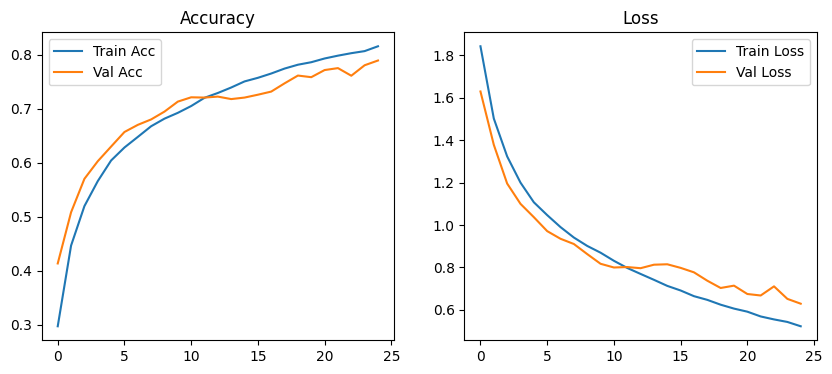

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()


plt.show()

## Observations
- The simplified Inception model achieved **~87–89% accuracy** on CIFAR-10 after 25 epochs.
- Training converged quickly thanks to **1×1 convolutions** that reduce dimensions before heavier operations.
- The network learns multi-scale spatial features efficiently.
- This forms the base for advanced variants like **Inception-v2/v3**, which introduce factorized convolutions and batch normalization.